## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

### Compute calibration matrix and distortion coefficients

In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
#%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32) # shape (54, 3)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # 

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        # cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()


# Read in image
img = cv2.imread('../camera_cal/calibration5.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

print("Calibration Matrix:")
print(mtx) 
print("\n")
print("Distortion Coefficient:")
print(dist)

Calibration Matrix:
[[1.15777942e+03 0.00000000e+00 6.67111050e+02]
 [0.00000000e+00 1.15282305e+03 3.86129068e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


Distortion Coefficient:
[[-0.24688833 -0.02372816 -0.00109843  0.00035105 -0.00259135]]


### Distortion correction to raw images

True

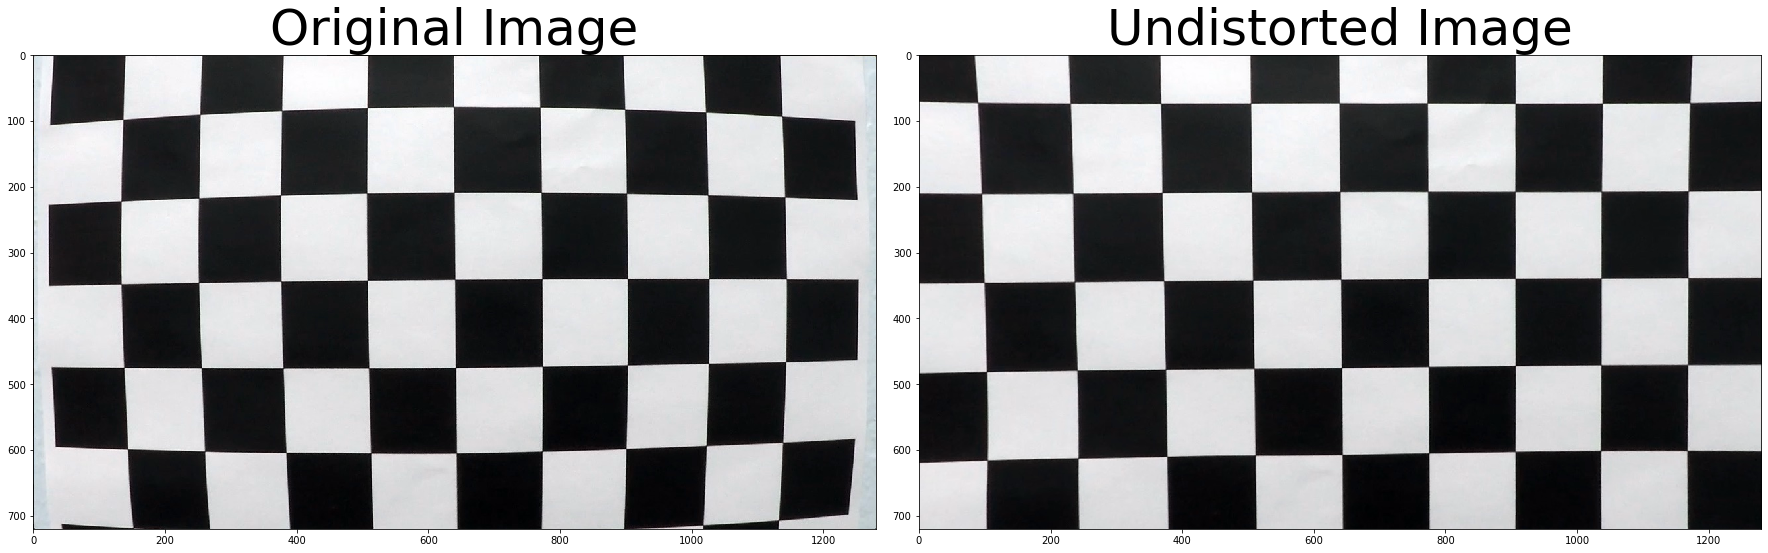

In [4]:
# Read in image
img = cv2.imread('../camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

undist = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# write output
cv2.imwrite('../output_images/undistort_output.jpg', undist)

### Color transforms and threshold combined binary image

True

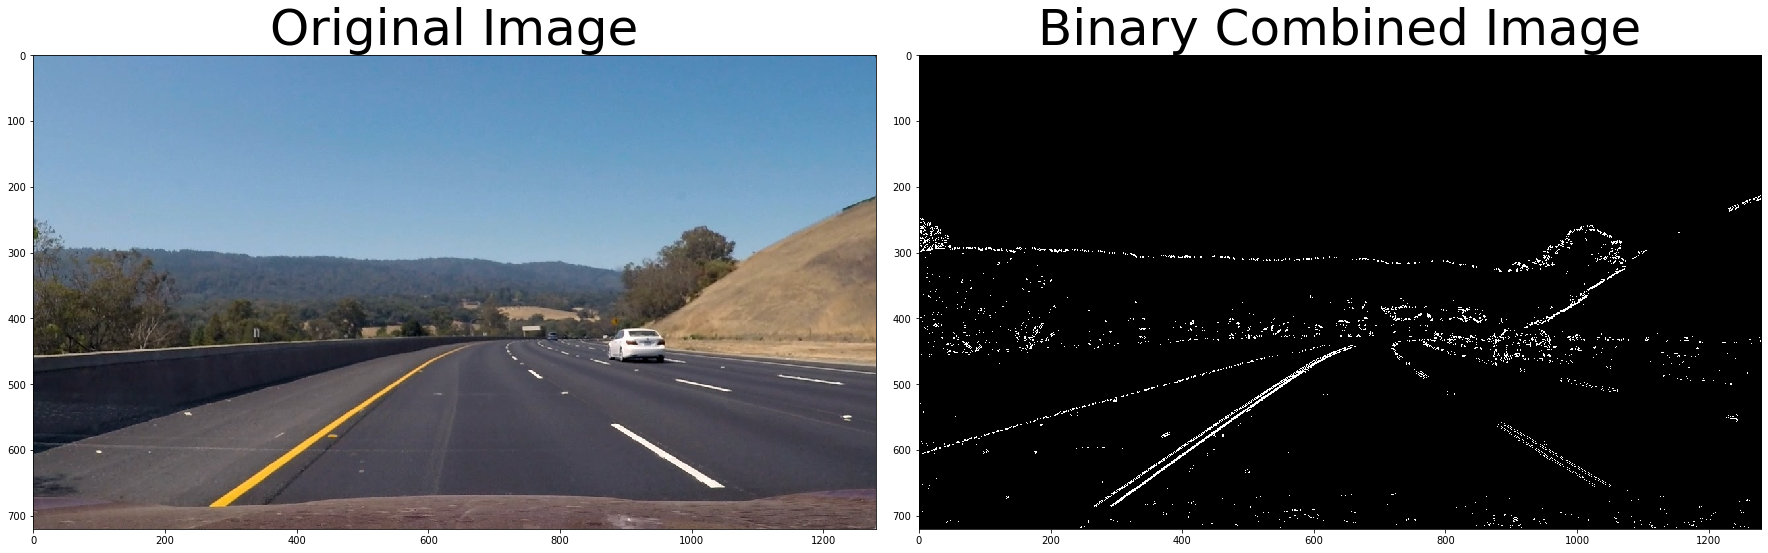

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle


# Read in an image
img = mpimg.imread('../test_images/test3.jpg')

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    arctan_sobel = np.arctan2(abs_sobely, abs_sobelx)
    binary_output = np.zeros_like(arctan_sobel)
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    binary_output[(arctan_sobel >= thresh_min) & (arctan_sobel <= thresh_max)] = 1
    return binary_output

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    if (orient == 'x'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif (orient == 'y'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    grad_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    magnitude = np.sqrt(np.square(sobelx) + np.square(sobely))
    scaled_magnitude = np.uint8(255*magnitude/np.max(magnitude))
    mag_binary = np.zeros_like(scaled_magnitude)
    thresh_min = mag_thresh[0]
    thresh_max = mag_thresh[1]
    mag_binary[(scaled_magnitude >= thresh_min) & (scaled_magnitude <= thresh_max)] = 1
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    arctan_sobel = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(arctan_sobel)
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    dir_binary[(arctan_sobel >= thresh_min) & (arctan_sobel <= thresh_max)] = 1
    return dir_binary

# Sobel kernel size
ksize = 3 # larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Binary Combined Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# write output
cv2.imwrite('../output_images/binary_combo_output.jpg', combined)

### Perspective transform to binary image using dist coefficient

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]


/usr/lib/python3/dist-packages/ipykernel_launcher.py:73: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:74: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


True

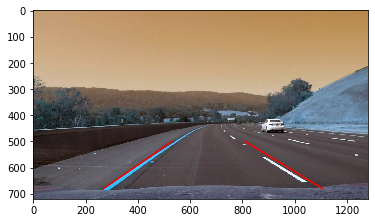

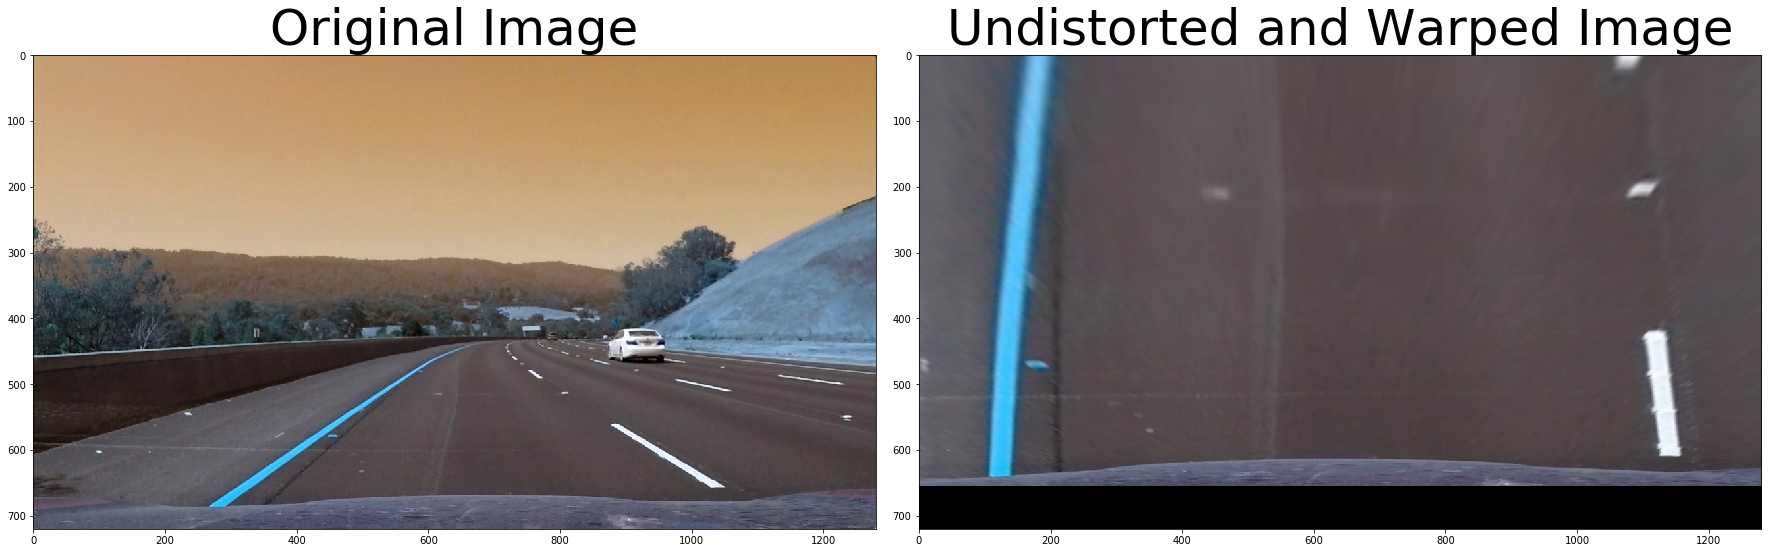

In [6]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# calibration matrix and distortion coefficients
mtx = mtx
dist = dist

# Read in an image
image = cv2.imread('../test_images/test3.jpg')
# image = cv2.imread('../camera_cal/calibration8.jpg')
# nx = 8 # inside corners in x
# ny = 6 # inside corners in y

# overlaid on the original.
ysize = image.shape[0]
xsize = image.shape[1]
color_select = np.float64(np.copy(image))
line_image = np.copy(image)

# Define our color criteria
red_threshold = 0
green_threshold = 0
blue_threshold = 0
rgb_threshold = [red_threshold, green_threshold, blue_threshold]

# Define a square region of interest (origin: x=0, y=0)
top_left = [530, 500]
top_right = [810, 500]
left_bottom = [270, 680]
right_bottom = [1105, 680]
# apex = [680, 400]

fit_left = np.polyfit((left_bottom[0], top_left[0]), (left_bottom[1], top_left[1]), 1)
fit_right = np.polyfit((right_bottom[0], top_right[0]), (right_bottom[1], top_right[1]), 1)
fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

# Mask pixels below the threshold
color_thresholds = (image[:,:,0] < rgb_threshold[0]) | \
                    (image[:,:,1] < rgb_threshold[1]) | \
                    (image[:,:,2] < rgb_threshold[2])

# Find the region inside the lines
XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                    (YY > (XX*fit_right[0] + fit_right[1])) & \
                    (YY < (XX*fit_bottom[0] + fit_bottom[1]))

test = [[1,2,3], [4,5,6]]
plt.imshow(test)
        
# Mask color selection
# color_select[color_thresholds] = [0,0,0]
# Find where image is both colored right and in the region
# line_image[~color_thresholds & region_thresholds] = [0,50,0]

region_thresholds = np.float64(region_thresholds)
region_thresholds = np.dstack((region_thresholds, region_thresholds, region_thresholds))
plt.imshow(region_thresholds)
temp = cv2.addWeighted(region_thresholds, 1.0, region_thresholds, 1.0, 0) 

# Display our two output images
# plt.imshow(temp)
plt.imshow(region_thresholds)
# plt.imshow(line_image)

# # Display our two output images
ploty = np.linspace(0, image.shape[0]-1, image.shape[0])
ploty = ploty[::-1]
ploty = ploty[[(ploty >= top_left[1])]]
ploty = ploty[[(ploty <= left_bottom[1])]]
left_fitx = (ploty - fit_left[1])/fit_left[0] # fitx since x > y and cannot plot
right_fitx = (ploty - fit_right[1])/fit_right[0]

plt.imshow(image)
    
plt.plot(left_fitx, ploty, color='red')
plt.plot(right_fitx, ploty, color='red')


def unwarp_undist_perspective(image, mtx, dist):
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    corners = [top_left, top_right, right_bottom, left_bottom]  # top_left -> top_right -> bottom_right -> bottom_left
    img_size = (image.shape[1], image.shape[0])
    src = np.float32([corners[0], corners[1], corners[2], corners[3]])
    offset = 100
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                      [img_size[0]-offset, img_size[1]-offset], 
                      [offset, img_size[1]-offset]]) # top_left -> top_right -> bottom_right -> bottom_left
    print(dst)
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped_undist = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    return warped_undist, M


warped_undist, M = unwarp_undist_perspective(image, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped_undist)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# write output
cv2.imwrite('../output_images/warped_straight_lines_output.jpg', warped_undist)

##### Detect lane pixels and fit to find the lane boundary

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


True

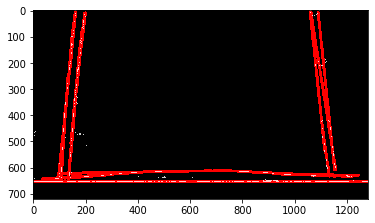

In [26]:
# Do all the relevant imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

# Gray previous warped perspective transform
gray = cv2.cvtColor(warped_undist,cv2.COLOR_RGB2GRAY)

# Define a kernel size for Gaussian smoothing / blurring to blur out dots
kernel_size = 7 # Must be an odd number (3, 5, 7...)
blur_gray = cv2.GaussianBlur(warped_undist,(kernel_size, kernel_size),0)

# Define our parameters for Canny and run it
low_threshold = 50
high_threshold = 60
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 3 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 100    # minimum number of votes (intersections in Hough grid cell)
min_line_length = 40 #minimum number of pixels making up a line
max_line_gap = 300    # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on a blank image
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 
# print(color_edges.shape)
# print(line_image.shape)
# print(edges)
# print(edges.shape)

# Draw the lines on the edge image
lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
print(lines_edges)
plt.imshow(lines_edges)

# write output
cv2.imwrite('../output_images/warped_line_edges_output.jpg', lines_edges)

### Determine the curvature of the lane and vehicle position with respect to center

In [22]:
import numpy as np

ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
left_fit_cr = np.polyfit(ploty * ym_per_pix, left_fitx * xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty * ym_per_pix, right_fitx * xm_per_pix, 2)

# Calculate the radius of curvature in meters for both lane lines
y_eval = np.max(ploty)
left_curverad = ((1 + (2 * left_fit_cr[0] * (y_eval * ym_per_pix) + left_fit_cr[1]) ** 2) ** (3/2)) / np.abs(2 * left_fit_cr[0])  ## Implement the calculation of the left line here
right_curverad = ((1 + (2 * right_fit_cr[0] * (y_eval * ym_per_pix) + right_fit_cr[1]) ** 2) ** (3/2)) / np.abs(2 *right_fit_cr[0])  ## Implement the calculation of the right line here

print(left_curverad, 'm', right_curverad, 'm')

3749536112840165.0 m 3564985763547513.5 m


### Warp the detected lane boundaries back onto the original image

True

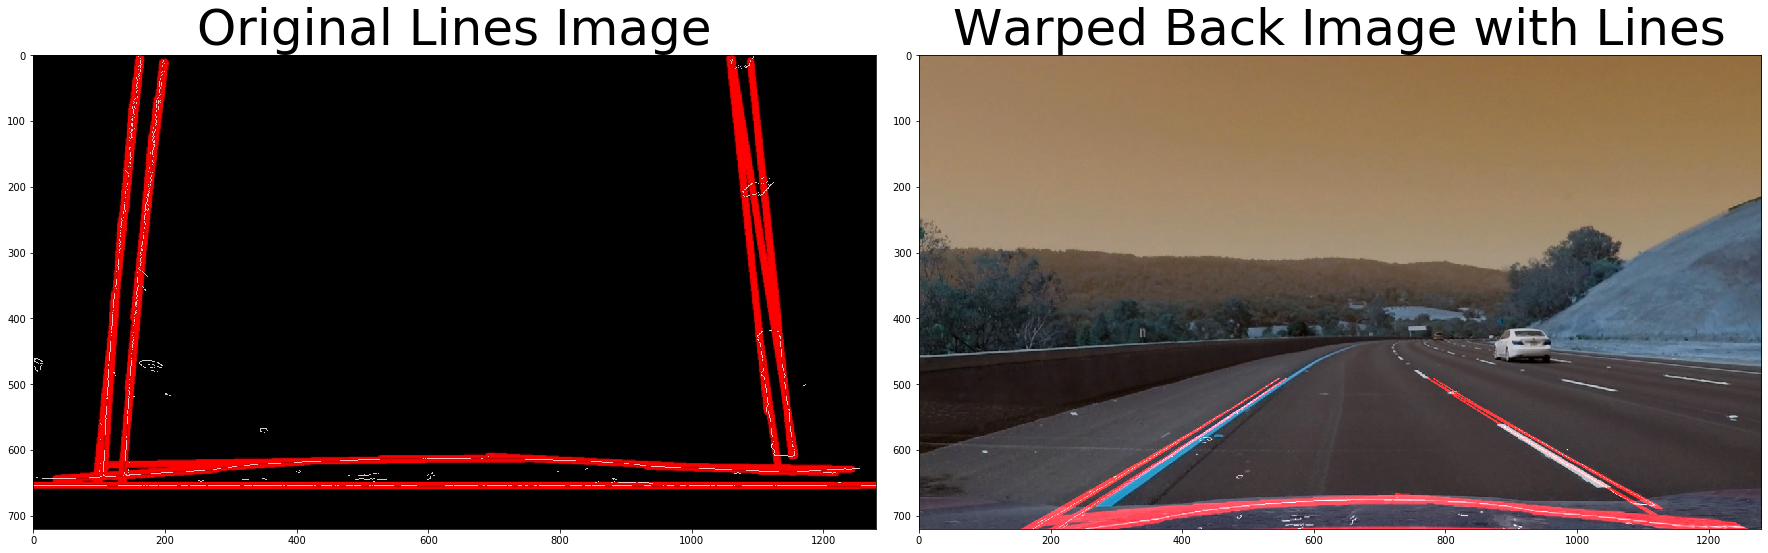

In [23]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# calibration matrix and distortion coefficients
mtx = mtx
dist = dist

# IMPT: Read saved image
#image = cv2.imread('../output_images/warped_straight_lines_output.jpg')
image = cv2.imread('../output_images/warped_line_edges_output.jpg')
ori_image = cv2.imread('../test_images/test3.jpg')

# Use same parameters as above but use Minv
def warp_back_perspective(image, mtx, dist):
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    corners = [top_left, top_right, right_bottom, left_bottom]  # top_left -> top_right -> bottom_right -> bottom_left
    img_size = (image.shape[1], image.shape[0])
    src = np.float32([corners[0], corners[1], corners[2], corners[3]])
    offset = 100
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                      [img_size[0]-offset, img_size[1]-offset], 
                      [offset, img_size[1]-offset]]) # top_left -> top_right -> bottom_right -> bottom_left
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped_back = cv2.warpPerspective(undist, Minv, img_size, flags=cv2.INTER_LINEAR)
    return warped_back, Minv


warp_back, Minv = warp_back_perspective(image, mtx, dist)
warp_back = cv2.addWeighted(ori_image, 0.8, warp_back, 1, 0) 

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Lines Image', fontsize=50)
ax2.imshow(warp_back)
ax2.set_title('Warped Back Image with Lines', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# write output
cv2.imwrite('../output_images/warped_back_line_edges_output.jpg', warp_back)

### Output visual display of the lane boundaries and estimation of lane curvature and vehicle position

Lane curvature:
3749536112840165.0 m 3564985763547513.5 m


Vehicle position:
3.6339285714285716 m from left lane


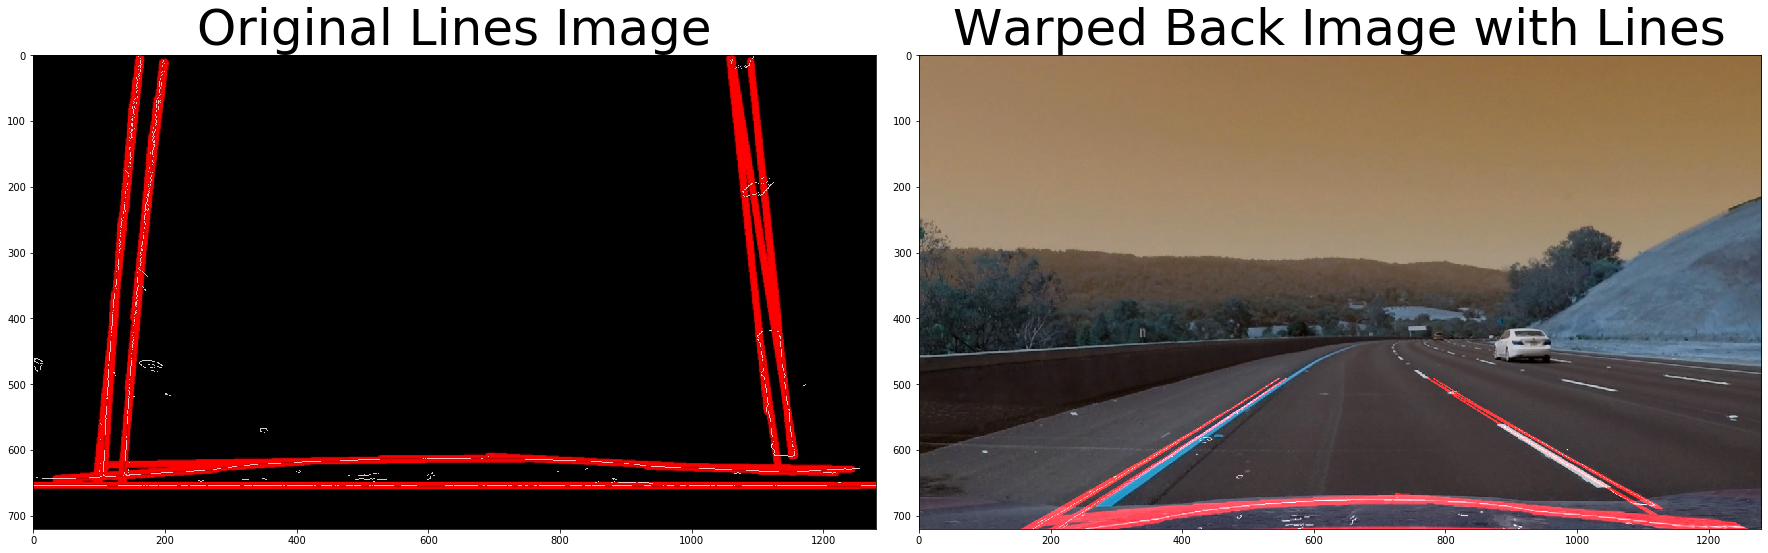

In [24]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Lines Image', fontsize=50)
ax2.imshow(warp_back)
ax2.set_title('Warped Back Image with Lines', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Lane curvature 
print("Lane curvature:")
print(left_curverad, 'm', right_curverad, 'm')
print("\n")

# Vehicle position = (left_bottom[0] + right_bottom[0])/2
vehicle_pos = (left_bottom[0] + right_bottom[0])/2
vehicle_pos = vehicle_pos * xm_per_pix # change to meters
print("Vehicle position:")
print(vehicle_pos, 'm from left lane')

### Output lane detection on video

In [25]:
# Import everything needed to edit/save/watch video clips
# !pip3 install moviepy
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [37]:
def process_image(image):
    #initial_img = mpimg.imread(image) # no need
    initial_img = image
    warped_undist, M = unwarp_undist_perspective(image, mtx, dist)

    gray = cv2.cvtColor(warped_undist,cv2.COLOR_RGB2GRAY)
    kernel_size = 7 # Must be an odd number (3, 5, 7...)
    blur_gray = cv2.GaussianBlur(warped_undist,(kernel_size, kernel_size),0)

    low_threshold = 50
    high_threshold = 60
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

    rho = 3 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 100    # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 40 #minimum number of pixels making up a line
    max_line_gap = 300    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

    color_edges = np.dstack((edges, edges, edges)) 
    lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
    
    warp_back, Minv = warp_back_perspective(lines_edges, mtx, dist)
    warp_back = cv2.addWeighted(initial_img, 0.8, warp_back, 1, 0) 
    
    result = warp_back
    return result

In [41]:
white_output = '../project_video_output.mp4'
clip1 = VideoFileClip('../project_video.mp4').subclip(0,15)
#clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   1%|          | 3/375 [00:00<00:15, 24.43it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
Moviepy - Building video ../project_video_output.mp4.
Moviepy - Writing video ../project_video_output.mp4

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:   2%|▏         | 7/375 [00:00<00:17, 20.83it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:   3%|▎         | 11/375 [00:00<00:18, 19.43it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:   4%|▍         | 15/375 [00:00<00:19, 18.35it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:   5%|▌         | 19/375 [00:01<00:22, 16.13it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:   6%|▌         | 21/375 [00:01<00:21, 16.19it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:   7%|▋         | 25/375 [00:01<00:21, 16.27it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:   8%|▊         | 29/375 [00:01<00:20, 16.60it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:   9%|▉         | 33/375 [00:01<00:20, 16.41it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  10%|▉         | 37/375 [00:02<00:19, 16.92it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  11%|█         | 41/375 [00:02<00:20, 16.29it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  12%|█▏        | 45/375 [00:02<00:21, 15.32it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  13%|█▎        | 47/375 [00:02<00:22, 14.77it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  14%|█▎        | 51/375 [00:03<00:23, 14.01it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  15%|█▍        | 55/375 [00:03<00:22, 14.32it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  15%|█▌        | 57/375 [00:03<00:23, 13.81it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  16%|█▌        | 59/375 [00:03<00:23, 13.19it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  17%|█▋        | 63/375 [00:03<00:22, 14.01it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  17%|█▋        | 65/375 [00:04<00:21, 14.10it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  18%|█▊        | 69/375 [00:04<00:21, 14.14it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  19%|█▉        | 73/375 [00:04<00:21, 13.92it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  20%|██        | 75/375 [00:04<00:21, 13.81it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  21%|██        | 79/375 [00:05<00:21, 13.63it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  22%|██▏       | 81/375 [00:05<00:22, 13.32it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  23%|██▎       | 85/375 [00:05<00:21, 13.77it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  23%|██▎       | 87/375 [00:05<00:21, 13.69it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  24%|██▎       | 89/375 [00:05<00:20, 13.88it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  25%|██▍       | 93/375 [00:06<00:20, 13.93it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  25%|██▌       | 95/375 [00:06<00:20, 13.52it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  26%|██▋       | 99/375 [00:06<00:21, 13.02it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  27%|██▋       | 101/375 [00:06<00:20, 13.39it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  28%|██▊       | 105/375 [00:07<00:21, 12.56it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  29%|██▊       | 107/375 [00:07<00:21, 12.52it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  30%|██▉       | 111/375 [00:07<00:21, 12.53it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  30%|███       | 113/375 [00:07<00:20, 12.96it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  31%|███       | 117/375 [00:08<00:19, 13.34it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  32%|███▏      | 119/375 [00:08<00:20, 12.79it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  33%|███▎      | 123/375 [00:08<00:20, 12.40it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  33%|███▎      | 125/375 [00:08<00:19, 12.55it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  34%|███▍      | 129/375 [00:09<00:19, 12.39it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  35%|███▌      | 133/375 [00:09<00:17, 13.50it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  36%|███▌      | 135/375 [00:09<00:17, 13.74it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  37%|███▋      | 139/375 [00:09<00:17, 13.82it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  38%|███▊      | 141/375 [00:09<00:18, 12.72it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  38%|███▊      | 143/375 [00:10<00:18, 12.68it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  39%|███▉      | 147/375 [00:10<00:17, 12.93it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  40%|████      | 151/375 [00:10<00:16, 13.57it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  41%|████      | 153/375 [00:10<00:15, 13.91it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  42%|████▏     | 157/375 [00:11<00:15, 13.98it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  43%|████▎     | 161/375 [00:11<00:15, 13.51it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  43%|████▎     | 163/375 [00:11<00:16, 12.96it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  45%|████▍     | 167/375 [00:11<00:15, 13.51it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  45%|████▌     | 169/375 [00:11<00:14, 13.88it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  46%|████▌     | 171/375 [00:12<00:15, 13.60it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  47%|████▋     | 175/375 [00:12<00:14, 13.44it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  47%|████▋     | 177/375 [00:12<00:15, 13.14it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  48%|████▊     | 181/375 [00:12<00:14, 13.19it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  49%|████▉     | 183/375 [00:13<00:14, 13.03it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  50%|████▉     | 187/375 [00:13<00:15, 12.50it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  50%|█████     | 189/375 [00:13<00:14, 12.65it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  51%|█████▏    | 193/375 [00:13<00:14, 12.28it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  52%|█████▏    | 195/375 [00:14<00:14, 12.70it/s, now=None]


[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]


t:  53%|█████▎    | 199/375 [00:14<00:13, 13.06it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  54%|█████▎    | 201/375 [00:14<00:13, 12.71it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  55%|█████▍    | 205/375 [00:14<00:13, 12.51it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  56%|█████▌    | 209/375 [00:15<00:12, 13.42it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  56%|█████▋    | 211/375 [00:15<00:12, 13.65it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  57%|█████▋    | 213/375 [00:15<00:12, 13.14it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  58%|█████▊    | 217/375 [00:15<00:12, 12.70it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  58%|█████▊    | 219/375 [00:15<00:12, 12.86it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  59%|█████▉    | 223/375 [00:16<00:11, 13.22it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  61%|██████    | 227/375 [00:16<00:11, 13.42it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  61%|██████    | 229/375 [00:16<00:10, 13.36it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  62%|██████▏   | 231/375 [00:16<00:10, 13.47it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  63%|██████▎   | 235/375 [00:17<00:11, 12.69it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  63%|██████▎   | 237/375 [00:17<00:11, 12.44it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  64%|██████▍   | 241/375 [00:17<00:10, 12.27it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  65%|██████▍   | 243/375 [00:17<00:10, 12.01it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  66%|██████▌   | 247/375 [00:18<00:10, 12.00it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  66%|██████▋   | 249/375 [00:18<00:10, 12.14it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  67%|██████▋   | 253/375 [00:18<00:10, 12.03it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  68%|██████▊   | 255/375 [00:18<00:10, 11.95it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  69%|██████▉   | 259/375 [00:19<00:09, 11.67it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  70%|██████▉   | 261/375 [00:19<00:09, 11.84it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  71%|███████   | 265/375 [00:19<00:09, 11.87it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  71%|███████   | 267/375 [00:19<00:09, 11.97it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  72%|███████▏  | 271/375 [00:20<00:08, 12.34it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  73%|███████▎  | 273/375 [00:20<00:08, 12.40it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  74%|███████▍  | 277/375 [00:20<00:08, 11.74it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  75%|███████▍  | 281/375 [00:20<00:07, 12.39it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  75%|███████▌  | 283/375 [00:21<00:07, 12.07it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  76%|███████▌  | 285/375 [00:21<00:07, 11.62it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  77%|███████▋  | 289/375 [00:21<00:07, 12.06it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  78%|███████▊  | 291/375 [00:21<00:06, 12.09it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  79%|███████▊  | 295/375 [00:22<00:06, 11.75it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  79%|███████▉  | 297/375 [00:22<00:06, 11.89it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  80%|████████  | 301/375 [00:22<00:06, 12.21it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  81%|████████  | 303/375 [00:22<00:06, 11.93it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  82%|████████▏ | 307/375 [00:23<00:05, 11.86it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  82%|████████▏ | 309/375 [00:23<00:05, 11.12it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  83%|████████▎ | 313/375 [00:23<00:05, 11.91it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  84%|████████▍ | 315/375 [00:23<00:04, 12.00it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  85%|████████▌ | 319/375 [00:24<00:04, 12.12it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  86%|████████▌ | 321/375 [00:24<00:04, 12.37it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  87%|████████▋ | 325/375 [00:24<00:04, 12.14it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  87%|████████▋ | 327/375 [00:24<00:03, 12.26it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  88%|████████▊ | 331/375 [00:25<00:03, 11.98it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  89%|████████▉ | 333/375 [00:25<00:03, 11.93it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  90%|████████▉ | 337/375 [00:25<00:03, 11.70it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  90%|█████████ | 339/375 [00:25<00:02, 12.03it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  91%|█████████▏| 343/375 [00:26<00:02, 11.44it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  92%|█████████▏| 345/375 [00:26<00:02, 11.40it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  93%|█████████▎| 349/375 [00:26<00:02, 11.95it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  94%|█████████▎| 351/375 [00:26<00:02, 11.69it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  95%|█████████▍| 355/375 [00:27<00:01, 11.68it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  95%|█████████▌| 357/375 [00:27<00:01, 12.13it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  96%|█████████▋| 361/375 [00:27<00:01, 11.80it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  97%|█████████▋| 363/375 [00:27<00:01, 11.87it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  98%|█████████▊| 367/375 [00:28<00:00, 11.86it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  98%|█████████▊| 369/375 [00:28<00:00, 11.59it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  99%|█████████▉| 373/375 [00:28<00:00, 11.80it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t: 100%|██████████| 375/375 [00:28<00:00, 12.03it/s, now=None]
                                                              

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]


t:  15%|█▌        | 190/1260 [08:03<01:02, 17.09it/s, now=None]

Moviepy - Done !
Moviepy - video ready ../project_video_output.mp4
CPU times: user 3min 23s, sys: 1.6 s, total: 3min 25s
Wall time: 29.9 s


In [42]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [45]:
white_output = '../challenge_video_output.mp4'
clip1 = VideoFileClip('../challenge_video.mp4').subclip(0,15)
#clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   1%|          | 3/450 [00:00<00:17, 26.15it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
Moviepy - Building video ../challenge_video_output.mp4.
Moviepy - Writing video ../challenge_video_output.mp4

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:   2%|▏         | 8/450 [00:00<00:20, 21.83it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:   3%|▎         | 12/450 [00:00<00:21, 20.73it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:   3%|▎         | 14/450 [00:00<00:21, 19.94it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:   4%|▍         | 18/450 [00:00<00:22, 19.10it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:   5%|▍         | 22/450 [00:01<00:22, 18.81it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:   6%|▌         | 27/450 [00:01<00:22, 18.73it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:   7%|▋         | 33/450 [00:01<00:21, 19.62it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:   8%|▊         | 36/450 [00:01<00:20, 19.94it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:   9%|▉         | 42/450 [00:02<00:20, 20.11it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  10%|█         | 47/450 [00:02<00:21, 18.70it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  11%|█▏        | 51/450 [00:02<00:23, 17.31it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  12%|█▏        | 53/450 [00:02<00:27, 14.49it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  13%|█▎        | 57/450 [00:03<00:29, 13.16it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  14%|█▎        | 61/450 [00:03<00:27, 14.15it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  14%|█▍        | 65/450 [00:03<00:26, 14.78it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  15%|█▌        | 69/450 [00:03<00:24, 15.28it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  16%|█▌        | 73/450 [00:04<00:24, 15.27it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  17%|█▋        | 75/450 [00:04<00:24, 15.06it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  18%|█▊        | 79/450 [00:04<00:23, 15.93it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  18%|█▊        | 83/450 [00:04<00:22, 16.35it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  19%|█▉        | 87/450 [00:05<00:22, 16.35it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  20%|██        | 91/450 [00:05<00:23, 15.48it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  21%|██        | 95/450 [00:05<00:22, 15.67it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  22%|██▏       | 99/450 [00:05<00:21, 16.07it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  23%|██▎       | 103/450 [00:06<00:22, 15.62it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  23%|██▎       | 105/450 [00:06<00:22, 15.11it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  24%|██▍       | 109/450 [00:06<00:23, 14.29it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  25%|██▍       | 111/450 [00:06<00:23, 14.63it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  26%|██▌       | 115/450 [00:06<00:22, 14.62it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  26%|██▌       | 117/450 [00:07<00:22, 14.99it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  27%|██▋       | 121/450 [00:07<00:21, 15.04it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  28%|██▊       | 125/450 [00:07<00:22, 14.60it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  28%|██▊       | 127/450 [00:07<00:22, 14.66it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  29%|██▉       | 131/450 [00:08<00:21, 14.92it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  30%|███       | 135/450 [00:08<00:20, 15.24it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  31%|███       | 139/450 [00:08<00:20, 15.16it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  31%|███▏      | 141/450 [00:08<00:21, 14.41it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  32%|███▏      | 145/450 [00:08<00:20, 14.73it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  33%|███▎      | 147/450 [00:09<00:19, 15.17it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  34%|███▎      | 151/450 [00:09<00:19, 15.13it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  34%|███▍      | 155/450 [00:09<00:19, 15.38it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  35%|███▌      | 159/450 [00:09<00:20, 14.35it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  36%|███▌      | 163/450 [00:10<00:19, 14.64it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  37%|███▋      | 167/450 [00:10<00:19, 14.51it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  38%|███▊      | 169/450 [00:10<00:19, 14.58it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  38%|███▊      | 173/450 [00:10<00:18, 15.15it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  39%|███▉      | 175/450 [00:10<00:18, 14.97it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  40%|███▉      | 179/450 [00:11<00:19, 13.96it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  41%|████      | 183/450 [00:11<00:17, 15.00it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  42%|████▏     | 187/450 [00:11<00:17, 14.86it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  42%|████▏     | 191/450 [00:12<00:18, 14.39it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  43%|████▎     | 193/450 [00:12<00:17, 14.90it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  44%|████▍     | 197/450 [00:12<00:17, 14.85it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  45%|████▍     | 201/450 [00:12<00:16, 14.90it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  46%|████▌     | 205/450 [00:13<00:16, 15.01it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  46%|████▋     | 209/450 [00:13<00:15, 15.07it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  47%|████▋     | 213/450 [00:13<00:16, 14.70it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  48%|████▊     | 217/450 [00:13<00:15, 15.03it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  49%|████▉     | 221/450 [00:14<00:15, 14.48it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  50%|█████     | 225/450 [00:14<00:15, 14.95it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  51%|█████     | 229/450 [00:14<00:14, 15.28it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  52%|█████▏    | 233/450 [00:14<00:14, 14.79it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  52%|█████▏    | 235/450 [00:15<00:14, 15.09it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  53%|█████▎    | 239/450 [00:15<00:14, 14.74it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  54%|█████▍    | 243/450 [00:15<00:14, 14.64it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  54%|█████▍    | 245/450 [00:15<00:13, 15.29it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  55%|█████▌    | 249/450 [00:15<00:13, 15.41it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  56%|█████▌    | 251/450 [00:16<00:14, 14.13it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  57%|█████▋    | 255/450 [00:16<00:13, 14.52it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  58%|█████▊    | 259/450 [00:16<00:12, 14.93it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  58%|█████▊    | 263/450 [00:16<00:12, 14.65it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  59%|█████▉    | 267/450 [00:17<00:12, 14.65it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  60%|██████    | 271/450 [00:17<00:12, 14.35it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  61%|██████    | 273/450 [00:17<00:12, 14.50it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  62%|██████▏   | 277/450 [00:17<00:11, 14.65it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  62%|██████▏   | 279/450 [00:18<00:11, 14.37it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  63%|██████▎   | 283/450 [00:18<00:11, 13.94it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  63%|██████▎   | 285/450 [00:18<00:12, 13.52it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  64%|██████▍   | 289/450 [00:18<00:11, 13.96it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  65%|██████▌   | 293/450 [00:19<00:10, 14.82it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  66%|██████▌   | 297/450 [00:19<00:10, 15.24it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  67%|██████▋   | 301/450 [00:19<00:09, 15.57it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  68%|██████▊   | 305/450 [00:19<00:09, 15.04it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  69%|██████▊   | 309/450 [00:20<00:09, 14.90it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  69%|██████▉   | 311/450 [00:20<00:09, 14.80it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  70%|███████   | 315/450 [00:20<00:08, 15.27it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  71%|███████   | 319/450 [00:20<00:08, 15.10it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  71%|███████▏  | 321/450 [00:20<00:08, 14.73it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  72%|███████▏  | 325/450 [00:21<00:08, 14.48it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  73%|███████▎  | 327/450 [00:21<00:08, 14.40it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  74%|███████▎  | 331/450 [00:21<00:08, 14.64it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  74%|███████▍  | 333/450 [00:21<00:07, 15.01it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  75%|███████▍  | 337/450 [00:21<00:07, 15.17it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  76%|███████▌  | 341/450 [00:22<00:07, 15.13it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  77%|███████▋  | 345/450 [00:22<00:06, 15.07it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  78%|███████▊  | 349/450 [00:22<00:06, 14.74it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  78%|███████▊  | 351/450 [00:22<00:06, 14.58it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  79%|███████▉  | 355/450 [00:23<00:06, 14.76it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  80%|███████▉  | 359/450 [00:23<00:06, 14.77it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  80%|████████  | 361/450 [00:23<00:06, 14.43it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  81%|████████  | 365/450 [00:23<00:06, 14.14it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  82%|████████▏ | 367/450 [00:24<00:05, 14.03it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  82%|████████▏ | 371/450 [00:24<00:05, 13.66it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  83%|████████▎ | 373/450 [00:24<00:05, 13.81it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  84%|████████▍ | 377/450 [00:24<00:05, 13.99it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  85%|████████▍ | 381/450 [00:25<00:04, 14.45it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  86%|████████▌ | 385/450 [00:25<00:04, 14.89it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  86%|████████▌ | 387/450 [00:25<00:04, 14.71it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  87%|████████▋ | 391/450 [00:25<00:03, 15.14it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  88%|████████▊ | 395/450 [00:25<00:03, 14.75it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  89%|████████▊ | 399/450 [00:26<00:03, 14.69it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  89%|████████▉ | 401/450 [00:26<00:03, 14.62it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  90%|█████████ | 405/450 [00:26<00:03, 14.39it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  90%|█████████ | 407/450 [00:26<00:03, 14.27it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  91%|█████████▏| 411/450 [00:27<00:02, 14.74it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  92%|█████████▏| 415/450 [00:27<00:02, 15.16it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  93%|█████████▎| 419/450 [00:27<00:02, 15.00it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  94%|█████████▎| 421/450 [00:27<00:01, 15.01it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  94%|█████████▍| 425/450 [00:27<00:01, 14.90it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  95%|█████████▌| 429/450 [00:28<00:01, 14.90it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  96%|█████████▌| 433/450 [00:28<00:01, 14.87it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  97%|█████████▋| 435/450 [00:28<00:01, 14.50it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  98%|█████████▊| 439/450 [00:28<00:00, 14.72it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  98%|█████████▊| 441/450 [00:29<00:00, 14.41it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  99%|█████████▉| 445/450 [00:29<00:00, 14.11it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  99%|█████████▉| 447/450 [00:29<00:00, 14.34it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t: 100%|█████████▉| 449/450 [00:29<00:00, 14.38it/s, now=None]
                                                              

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]


t:  15%|█▌        | 190/1260 [14:23<01:02, 17.09it/s, now=None]

Moviepy - Done !
Moviepy - video ready ../challenge_video_output.mp4
CPU times: user 3min 43s, sys: 1.33 s, total: 3min 45s
Wall time: 30.5 s


In [46]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [47]:
white_output = '../harder_challenge_video_output.mp4'
clip1 = VideoFileClip('../harder_challenge_video.mp4').subclip(0,15)
#clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   1%|          | 3/375 [00:00<00:15, 23.44it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
Moviepy - Building video ../harder_challenge_video_output.mp4.
Moviepy - Writing video ../harder_challenge_video_output.mp4

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:   1%|▏         | 5/375 [00:00<00:18, 20.21it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:   2%|▏         | 9/375 [00:00<00:20, 18.28it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:   3%|▎         | 13/375 [00:00<00:21, 16.83it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:   5%|▍         | 17/375 [00:00<00:20, 17.13it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:   6%|▌         | 21/375 [00:01<00:21, 16.14it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:   7%|▋         | 25/375 [00:01<00:22, 15.88it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:   8%|▊         | 29/375 [00:01<00:21, 16.44it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:   9%|▉         | 33/375 [00:01<00:20, 16.44it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  10%|▉         | 37/375 [00:02<00:20, 16.82it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  11%|█         | 41/375 [00:02<00:19, 17.04it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  12%|█▏        | 45/375 [00:02<00:19, 16.60it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  13%|█▎        | 49/375 [00:02<00:20, 15.60it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  14%|█▎        | 51/375 [00:03<00:21, 15.14it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  15%|█▍        | 55/375 [00:03<00:21, 14.85it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  15%|█▌        | 57/375 [00:03<00:21, 15.02it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  16%|█▋        | 61/375 [00:03<00:21, 14.55it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  17%|█▋        | 63/375 [00:03<00:21, 14.29it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  18%|█▊        | 67/375 [00:04<00:23, 13.26it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  18%|█▊        | 69/375 [00:04<00:24, 12.70it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  19%|█▉        | 73/375 [00:04<00:22, 13.18it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  21%|██        | 77/375 [00:05<00:22, 13.51it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  21%|██        | 79/375 [00:05<00:22, 13.44it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  22%|██▏       | 81/375 [00:05<00:22, 12.83it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  23%|██▎       | 85/375 [00:05<00:21, 13.25it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  23%|██▎       | 87/375 [00:05<00:22, 12.90it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  24%|██▍       | 91/375 [00:06<00:21, 13.28it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  25%|██▌       | 95/375 [00:06<00:20, 13.54it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  26%|██▌       | 97/375 [00:06<00:19, 13.94it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  26%|██▋       | 99/375 [00:06<00:19, 14.03it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  27%|██▋       | 103/375 [00:07<00:22, 12.15it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  28%|██▊       | 105/375 [00:07<00:23, 11.73it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  29%|██▊       | 107/375 [00:07<00:24, 11.15it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  30%|██▉       | 111/375 [00:07<00:21, 12.06it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  30%|███       | 113/375 [00:07<00:22, 11.88it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  31%|███       | 117/375 [00:08<00:21, 12.16it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  32%|███▏      | 119/375 [00:08<00:20, 12.66it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  33%|███▎      | 123/375 [00:08<00:19, 12.85it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  33%|███▎      | 125/375 [00:08<00:19, 12.95it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  34%|███▍      | 129/375 [00:09<00:19, 12.85it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  35%|███▌      | 133/375 [00:09<00:18, 13.25it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  36%|███▌      | 135/375 [00:09<00:18, 12.69it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  37%|███▋      | 137/375 [00:09<00:18, 13.05it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  38%|███▊      | 141/375 [00:10<00:18, 12.81it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  38%|███▊      | 143/375 [00:10<00:17, 13.13it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  39%|███▉      | 147/375 [00:10<00:17, 13.21it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  40%|███▉      | 149/375 [00:10<00:16, 13.42it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  41%|████      | 153/375 [00:10<00:17, 12.87it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  42%|████▏     | 157/375 [00:11<00:16, 13.34it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  42%|████▏     | 159/375 [00:11<00:16, 12.93it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  43%|████▎     | 163/375 [00:11<00:15, 13.54it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  44%|████▍     | 165/375 [00:11<00:15, 13.73it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  45%|████▌     | 169/375 [00:12<00:14, 14.07it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  46%|████▌     | 171/375 [00:12<00:14, 13.72it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  47%|████▋     | 175/375 [00:12<00:14, 13.97it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  47%|████▋     | 177/375 [00:12<00:13, 14.16it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  48%|████▊     | 181/375 [00:12<00:13, 14.15it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  49%|████▉     | 183/375 [00:13<00:13, 13.78it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  49%|████▉     | 185/375 [00:13<00:14, 12.95it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  50%|█████     | 189/375 [00:13<00:13, 13.39it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  51%|█████▏    | 193/375 [00:13<00:13, 13.66it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  52%|█████▏    | 195/375 [00:14<00:13, 13.56it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  53%|█████▎    | 199/375 [00:14<00:13, 13.13it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  54%|█████▎    | 201/375 [00:14<00:12, 13.38it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  55%|█████▍    | 205/375 [00:14<00:12, 13.35it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  55%|█████▌    | 207/375 [00:14<00:12, 13.35it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  56%|█████▌    | 209/375 [00:15<00:12, 13.13it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  57%|█████▋    | 213/375 [00:15<00:12, 13.40it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  57%|█████▋    | 215/375 [00:15<00:12, 13.11it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  58%|█████▊    | 219/375 [00:15<00:12, 12.38it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  59%|█████▉    | 221/375 [00:16<00:12, 12.36it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  60%|██████    | 225/375 [00:16<00:13, 11.25it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  61%|██████    | 227/375 [00:16<00:13, 11.14it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  62%|██████▏   | 231/375 [00:16<00:12, 11.08it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  62%|██████▏   | 233/375 [00:17<00:12, 10.99it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  63%|██████▎   | 237/375 [00:17<00:12, 11.19it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  64%|██████▎   | 239/375 [00:17<00:12, 10.84it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  64%|██████▍   | 241/375 [00:17<00:11, 11.32it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  65%|██████▌   | 245/375 [00:18<00:11, 11.40it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  66%|██████▌   | 247/375 [00:18<00:11, 11.49it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  67%|██████▋   | 251/375 [00:18<00:10, 11.81it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  67%|██████▋   | 253/375 [00:18<00:10, 11.25it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  69%|██████▊   | 257/375 [00:19<00:10, 11.38it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  69%|██████▉   | 259/375 [00:19<00:10, 11.37it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  70%|███████   | 263/375 [00:19<00:09, 11.49it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  71%|███████   | 265/375 [00:19<00:09, 12.09it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  72%|███████▏  | 269/375 [00:20<00:08, 11.84it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  72%|███████▏  | 271/375 [00:20<00:08, 11.90it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  73%|███████▎  | 275/375 [00:20<00:08, 11.90it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  74%|███████▍  | 277/375 [00:20<00:08, 11.80it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  75%|███████▍  | 281/375 [00:21<00:08, 10.86it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  75%|███████▌  | 283/375 [00:21<00:08, 10.66it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  76%|███████▌  | 285/375 [00:21<00:08, 10.45it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  77%|███████▋  | 289/375 [00:22<00:08, 10.45it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  78%|███████▊  | 291/375 [00:22<00:07, 10.64it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  78%|███████▊  | 293/375 [00:22<00:07, 10.36it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  79%|███████▉  | 297/375 [00:22<00:07, 10.67it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  80%|███████▉  | 299/375 [00:23<00:06, 11.12it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  81%|████████  | 303/375 [00:23<00:06, 11.09it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  81%|████████▏ | 305/375 [00:23<00:06, 11.24it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  82%|████████▏ | 309/375 [00:23<00:05, 11.11it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  83%|████████▎ | 311/375 [00:24<00:05, 10.74it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  84%|████████▍ | 315/375 [00:24<00:05, 10.63it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  85%|████████▍ | 317/375 [00:24<00:05, 11.14it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  86%|████████▌ | 321/375 [00:25<00:04, 11.26it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  86%|████████▌ | 323/375 [00:25<00:04, 11.64it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  87%|████████▋ | 327/375 [00:25<00:04, 11.71it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  88%|████████▊ | 329/375 [00:25<00:03, 12.18it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  89%|████████▉ | 333/375 [00:26<00:03, 12.03it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  89%|████████▉ | 335/375 [00:26<00:03, 12.52it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  90%|█████████ | 339/375 [00:26<00:02, 12.14it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  91%|█████████ | 341/375 [00:26<00:02, 12.21it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  92%|█████████▏| 345/375 [00:27<00:02, 11.92it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  93%|█████████▎| 347/375 [00:27<00:02, 11.73it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  93%|█████████▎| 349/375 [00:27<00:02, 10.98it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  94%|█████████▍| 353/375 [00:27<00:01, 11.63it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  95%|█████████▍| 355/375 [00:27<00:01, 11.26it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  96%|█████████▌| 359/375 [00:28<00:01, 11.62it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  96%|█████████▋| 361/375 [00:28<00:01, 11.91it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  97%|█████████▋| 365/375 [00:28<00:00, 12.39it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  98%|█████████▊| 367/375 [00:28<00:00, 12.05it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  99%|█████████▉| 371/375 [00:29<00:00, 12.01it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t:  99%|█████████▉| 373/375 [00:29<00:00, 11.90it/s, now=None]

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]



t: 100%|██████████| 375/375 [00:29<00:00, 12.20it/s, now=None]
                                                              

[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]


t:  15%|█▌        | 190/1260 [15:44<01:02, 17.09it/s, now=None]

Moviepy - Done !
Moviepy - video ready ../harder_challenge_video_output.mp4
CPU times: user 3min 13s, sys: 1.3 s, total: 3min 15s
Wall time: 30.8 s


In [48]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))